# Transfer Learning with Pytorch

In this excercise, you will implement a 2-class classification neural network, using transfer learning from a pre-trained resnet18 network. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve (but not identical). The pre-trained network could have been trained on a different dataset and sometimes also on a different task. The important thing is that it would be a related task and a realted dataset. This way, we can leverage previous learneinng to solve the new problem (instead of training the model from scratch). The ResNet18 model was pre-trained on the [ImageNet](http://image-net.org/index) dataset (a large dataset consisting of 1.4M images and 1000 classes). 

Transfer learning can be used in two ways:
1. Feature extractor: Here we remove top layers, freeze the weights of all remaining layers, add a new fully connected layers on top of the pretrained model. Then. we train only these new layers to solve the new task.
2. Fine tuning: Here we unfreezing the entire model (or part of it), add a new fully connected layers on top of the pre-trained model (as before) and re-train the entire model on the new data with a very low learning rate. We can use either end-to-end re-training, or re-train only part of the network.

### CIFAR-10 Dataset:

In this assignment, you will need to perform transfer learning using the ResNet18 network in order to classify and discern between images of cats and dogs in a different dataset: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 



# Part 1- Feature Extractor

In this part of the exercise, you need to classify images of 'Cat' and 'Dog' by using transfer learning with the feature extractor approach and a pre-trained ResNet18 network.

The pre-trained model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers. You will need to extract the image representation that should be fed into a classifier. For the classifier, please use a single fully-connected layer. 


In order to make things efficient, start by using the ResNet18 network in order to extract image represetnations for the images in CIFAR-10 dataset. Please make sure to this only once (please do not extract the image representations each time it is needed in the training phase)! You can store the resulting image representations as feature vectors and train the classifier using these vectors. At test time, you can merge both network in order to achive a single end-to-end classifier.  
Note: This is different from what you saw in the recitation (dl_r4_cnns).

At the test time, you can merge the feature extraction netowork with the new prediction head, in order to recive a "full solution".


**Let's first import all the packages that you will need during this part of assignment:**

In [129]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import time

import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

The ResNet18 network requires images of at least 200x200 pixels. However, the CIFAR-10 dataset consists of small images of 32x32 pixels. Hence, you will need to reshape the images before we use them into the ResNet18 network.
Additionally, you will need to match the normalization used while training the ResNet18: each color channel should be normalized separately. The channel means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

**Use the transforms library from  torchvision and definethese transformations:**

In [130]:
# Specify transforms using torchvision.transforms as transforms library
### START CODE HERE ###
preprocessing = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

#### Load CIFAR10 dataset and transform dataset from torchvision:

In [131]:
### START CODE HERE ###
cifar10_train = torchvision.datasets.CIFAR10('cifar10', train=True, download=True, transform=preprocessing)
cifar10_test = torchvision.datasets.CIFAR10('cifar10', train=False, download=True, transform=preprocessing)

Files already downloaded and verified
Files already downloaded and verified


**Note that the CIFAR10 data set includes 10 labels. Please extract from the entire dataset, only the images with 'Cat' or 'Dog' labels.
In order to make the training process faster, you will need to trim the train set to 800 training images of each label (800 dogs and 800 cats). The test set should be trimmed to 250 images of cats and 250 images of dogs.**

In [132]:
# Note: In order to separating the data/label you can apply "classes"/"targets" methods on CIFAR10 data sets
### START CODE HERE ###
class CatsAndDogsDataset(torch.utils.data.Dataset):
    def __init__(self, cifar, is_train):
        super().__init__()
        
        self.cifar = cifar
        
        # Extract the indices of all the images of cats and dogs
        cat_indices = self._get_class_indices(cifar, 'cat', is_train)
        dog_indices = self._get_class_indices(cifar, 'dog', is_train)
        
        # Concatenate the indices of cats and dogs into a single array
        self.data_indices = np.concatenate([cat_indices, dog_indices], axis=0)
        
        # Create labels, 0 for cats and 1 for dogs
        cat_labels = np.zeros(len(cat_indices), dtype=np.int64)
        dog_labels = np.ones(len(dog_indices), dtype=np.int64)
        
        # Concatenate labels into a single array
        self.labels = np.concatenate([cat_labels, dog_labels], axis=0)
        
        # Shuffle data
        self.data_indices, self.labels = self._shuffle_data(self.data_indices, self.labels)
        
    def _get_class_indices(self, cifar, class_name, is_train):
        # Translate class to index in the CIFAR10 dataset
        class_index = cifar.class_to_idx[class_name]
        
        # Take all the indices of the desired class
        indices = [i for i, label in enumerate(cifar.targets) if label == class_index]
        
        # Trim the dataset
        if is_train:
            indices = indices[:800]
        else:
            indices = indices[:250]

        return indices
    
    def _shuffle_data(self, data_indices, labels):
        # Shuffle data. We will concatenate class indices and labels together
        # so they don't get mixed when shuffling
        
        # Add a second dimension to concatenate indices and labels on
        data_indices = np.expand_dims(data_indices, axis=1)
        labels = np.expand_dims(labels, axis=1)
        
        # Concatenate each index with its associated label
        concatenated_data = np.concatenate([data_indices, labels], axis=-1)
        
        # Shuffle the concatenated array
        np.random.shuffle(concatenated_data)
        
        # Split again the array into indices and labels
        data_indices = concatenated_data[:, 0]
        labels = concatenated_data[:, 1].astype(np.float32)
        
        return data_indices, labels
    
    def __len__(self):
        return len(self.data_indices)
    
    def __getitem__(self, idx):
        cifar_idx = self.data_indices[idx]
        
        return self.cifar.__getitem__(cifar_idx)[0], self.labels[idx]

In [133]:
train_dataset = CatsAndDogsDataset(cifar10_train, is_train=True)
test_dataset = CatsAndDogsDataset(cifar10_test, is_train=False)

**Download the ResNet18 Network from torchvision.models (as seen in the tutorial):**

In [134]:
# Creating a device, we will use a CUDA GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [135]:
### START CODE HERE ###
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

In [136]:
# Move model to our selected device
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Now, use the pre-trained Resnet18 to extract feautres from the CIFAR10 dataset and feed your classifier with these feature vectors. To do that, you need to cut the head of the pre-trained ResNet18 model, then feed the model with the CIFAR10 data sets (train and test).  The resulting image representations should be "flattened" and used as feature vectors:

In [137]:
# Remove head
resnet18_feature_extractor = torch.nn.Sequential(*(list(resnet18.children())[:-1]))

In [138]:
def extract_features(feature_extractor, dataset, device='cpu'):
    image_features = []
    labels = []

    for image, label in dataset:
        
        images_batch = image.unsqueeze(0)
        images_batch = images_batch.to(device)
        
        features = feature_extractor(images_batch).squeeze()
        image_features.append(features)
        labels.append(label)
        
    image_features = torch.stack(image_features).detach().cpu()
    labels = np.array(labels)
    
    return image_features, labels

In [139]:
train_image_features, train_labels = extract_features(resnet18_feature_extractor, train_dataset, device)
train_image_features.shape

torch.Size([1600, 512])

In [140]:
test_image_features, test_labels = extract_features(resnet18_feature_extractor, test_dataset, device)
test_image_features.shape

torch.Size([500, 512])

# Logistic Regression with scikit-learn library:

#### Here, you need to use a logistic regession model from scikit-learn and train it with the data you prepared above. You need to calculate and report the accuracy and AUC for the train and test sets and explain your results.

In [141]:
### START CODE HERE ###
lr = LogisticRegression(max_iter=1000)

In [142]:
train_image_features_array = train_image_features.numpy()
test_image_features_array = test_image_features.numpy()

In [143]:
lr.fit(train_image_features_array, train_labels)

LogisticRegression(max_iter=1000)

#### Train accuracy and AUC

In [144]:
def get_accuracy(true_labels, predictions):
    return (true_labels == predictions).sum() / len(true_labels)

In [145]:
predictions = lr.predict(train_image_features_array)

In [146]:
accuracy = get_accuracy(train_labels, predictions)
print(f'Train Accuracy: {accuracy}')

Train Accuracy: 0.81125


In [147]:
score = roc_auc_score(train_labels, predictions)
print(f'Train AUC Score: {score}')

Train AUC Score: 0.81125


#### Test accuracy and AUC

In [148]:
predictions = lr.predict(test_image_features_array)

In [149]:
accuracy = get_accuracy(test_labels, predictions)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.654


In [150]:
score = roc_auc_score(test_labels, predictions)
print(f'Test AUC Score: {score}')

Test AUC Score: 0.654


#### Explaning results

The training accuracy and AUC are good over 81%, while the test metrics are not great, at 65% AUC. In addition, we can see a big gap when comparing the results on train and test set, which might be an indication of overfitting.

# Logistic Regression with pytorch:

#### Next, you need to use a logistic regession using pythourch as follows:


1. Explain the choice of architecture in the head of the neural network.
2. Plot training loss per epoch.
3. Plot AUC per epoch for train and validation sets.
4. Explain your results and findings.
5. Does adding one or two hidden layers affect the generalization capabilities of the model?

#### Define the model:

In [151]:
### START CODE HERE ###

# Using the default parameters it will create a logistic regression model. 
# There are additional parameters to add hidden layers if desired.
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_hidden_layers=0, hidden_size=256):
        super().__init__()

        layer_list = []
        
        if (num_hidden_layers > 0):
            layer = nn.Linear(input_size, hidden_size)
            layer_list.append(layer)
            
            relu = nn.ReLU()
            layer_list.append(relu)
            
            if (num_hidden_layers > 1):
                for i in range(num_hidden_layers-1):
                    layer = nn.Linear(hidden_size, hidden_size)
                    layer_list.append(layer)
                    layer_list.append(relu)

            # Linear layer of output size 1 because in binary classification
            # we predict whether or not the input pertains to the class
            layer = nn.Linear(hidden_size, 1)
            layer_list.append(layer)
        else:
            # Linear layer of output size 1 because in binary classification
            # we predict whether or not the input pertains to the class
            linear = nn.Linear(input_size, 1)
            layer_list.append(linear)
        
        self.layers = nn.ModuleList(layer_list)
       
        # The sigmoid layer will convert the outputs of the linear layer
        # into a probability
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Apply every layer in our module list
        for layer in self.layers:
            x = layer(x)

        # Apply the sigmoid
        x = self.sigmoid(x)
        
        # Remove last dimension of size 1
        x = x.squeeze(dim=-1)
        
        return x

In [152]:
logistic_regression_model = LogisticRegressionModel(input_size=512)
logistic_regression_model

LogisticRegressionModel(
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

##### Explain the choice of architecture in the head of the neural network.

The model will need to discern between two classes, so the thing in the image will either be a cat or a dog. So for the head of the model we are using a linear layer with a single unit, and a sigmoid function to output a value between 0 and 1, i.e. a "probability" of the image being a dog.

An output of 1 will mean the image is a dog, and 0 that the image is a cat.

#### Training and validation:

In [153]:
### START CODE HERE ###

# Defines one training step
def train_step(model, dataloader, optimizer, criterion, metric=None, device='cpu'):
    # put the model in training mode
    model.train()

    epoch_loss = 0
    
    if metric is not None:
        metric_score = 0

    # Run over all the dataset in batches
    for step, data in enumerate(dataloader):
        # retrieve data from the current batch
        X, y = data
        
        X = X.to(device)
        y = y.to(device)
        
        # we need to zero the gradient of the optimizer in each step
        optimizer.zero_grad()

        # generate predictions
        outputs = model(X)

        # calculate loss
        loss = criterion(outputs, y)

        # backward pass
        loss.backward()
        
        # let optimizer know we did an step (it's important if for example we were using learning rate decay)
        optimizer.step()

        # accumulate loss
        epoch_loss += loss.item()
        
        # accumulate metric
        if metric is not None:
            metric_score += metric(y.cpu().numpy(), outputs.detach().cpu().numpy())

    # we currently have a sum of the losses, so average them
    epoch_loss /= len(dataloader)
       
    # average metric
    if metric is not None:
        metric_score /= len(dataloader)
       
    # if we provided a metric function, return two outputs (the loss and the metric), else return just the loss
    result = (epoch_loss, metric_score) if metric is not None else epoch_loss
            
    return result

In [154]:
def evaluate(model, dataloader, criterion, metric=False, device='cpu'):
    # put the model in evaluation mode
    model.eval()

    epoch_loss = 0
    
    if metric is not None:
        metric_score = 0

    # do not accumualate gradients for tensors during evaluation
    with torch.no_grad():
        for _, data in enumerate(dataloader):
            # retrieve data from current batch
            X, y = data
            
            X = X.to(device)
            y = y.to(device)

            # generate predictions
            outputs = model(X)

            # calculate loss
            loss = criterion(outputs, y)

            # accumulate loss
            epoch_loss += loss.item()
            
            # accumulate metric, if any
            if metric is not None:
                metric_score += metric(y.cpu().numpy(), outputs.detach().cpu().numpy())
                
    # average loss over all the batches
    epoch_loss /= len(dataloader)
       
    # average metric over all the batches
    if metric is not None:
        metric_score /= len(dataloader)
        
    # if we provided a metric function, return two outputs (the loss and the metric), else return just the loss
    result = (epoch_loss, metric_score) if metric is not None else epoch_loss

    return result

In [155]:
def train_model(model, trainloader, validationloader, epochs=2, learning_rate=1e-3, mode='classificaton', metric_function=None, device='cpu', verbose=1):

    print("Training started...")

    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # We will use binary cross-entropy loss for classification and mean squared error loss for regression
    criterion = torch.nn.BCELoss() if mode == 'classificaton' else torch.nn.MSELoss()

    losses = []
    val_losses = []
        
    if metric_function is not None:
        metric_scores = []
        val_metric_scores = []

    # Train and validate for the number of epoch specified as parameter
    for epoch in range(epochs):
        # perform a training step
        train_loss = train_step(model, trainloader, optimizer, criterion, metric_function, device)
        if metric_function is not None:
            train_loss, train_metric_score = train_loss

        if (verbose):
            # perform an evaluation step
            val_loss = evaluate(model, validationloader, criterion, metric_function, device)
            if metric_function is not None:
                val_loss, val_metric_score = val_loss

            print(f'epoch {epoch} loss {train_loss} val_loss {val_loss}')

            # save losses for plotting them later
            losses.append(train_loss)
            val_losses.append(val_loss)
            
            # save metrics for plotting them later
            if metric_function is not None:
                metric_scores.append(train_metric_score)
                val_metric_scores.append(val_metric_score)


    # we will return a dictionary containing the losses
    history = {'loss': losses, 'val_loss': val_losses}
    
    # and also the metrics if there were any
    if metric_function is not None:
        history['metric'] = metric_scores
        history['val_metric'] = val_metric_scores

    return history

In [156]:
def get_features_dataloader(features, labels, batch_size, shuffle):
    # Create tensors from numpy arrays
    features_tensor = torch.from_numpy(features)
    labels_tensor = torch.from_numpy(labels.astype(np.float32))
    
    # Create a dataset from the tensors
    features_dataset = torch.utils.data.TensorDataset(features_tensor, labels_tensor)
    
    # Create a dataloader from the dataset above
    features_dataloader = torch.utils.data.DataLoader(features_dataset, batch_size=batch_size, shuffle=shuffle)
    
    return features_dataloader

In [157]:
train_dataloader = get_features_dataloader(train_image_features_array, train_labels, batch_size=32, shuffle=True)
test_dataloader = get_features_dataloader(test_image_features_array, test_labels, batch_size=32, shuffle=False)

In [158]:
image, labels = next(iter(train_dataloader))
image.shape, labels.shape

(torch.Size([32, 512]), torch.Size([32]))

In [159]:
image, labels = next(iter(test_dataloader))
image.shape, labels.shape

(torch.Size([32, 512]), torch.Size([32]))

In [160]:
# Train the model
history = train_model(logistic_regression_model, train_dataloader, test_dataloader, epochs=50, learning_rate=1e-3, metric_function=roc_auc_score)

Training started...
epoch 0 loss 0.6976746070384979 val_loss 0.7131290957331657
epoch 1 loss 0.6999014461040497 val_loss 0.6937353238463402
epoch 2 loss 0.7035570919513703 val_loss 0.6981324441730976
epoch 3 loss 0.6991552877426147 val_loss 0.6963935047388077
epoch 4 loss 0.6947609281539917 val_loss 0.6930332519114017
epoch 5 loss 0.6966975605487824 val_loss 0.6932752318680286
epoch 6 loss 0.6991182506084442 val_loss 0.6924350522458553
epoch 7 loss 0.7026621782779694 val_loss 0.6935486271977425
epoch 8 loss 0.6998035144805909 val_loss 0.7003213949501514
epoch 9 loss 0.7034215235710144 val_loss 0.6921772994101048
epoch 10 loss 0.6952500200271606 val_loss 0.6938508562743664
epoch 11 loss 0.7052202987670898 val_loss 0.7213779091835022
epoch 12 loss 0.7053253066539764 val_loss 0.6922810487449169
epoch 13 loss 0.7001823246479034 val_loss 0.6939633898437023
epoch 14 loss 0.7086967051029205 val_loss 0.7210409566760063
epoch 15 loss 0.7038611686229705 val_loss 0.7127814330160618
epoch 16 loss 

#### Visualizing the plots:

##### Loss vs epoch

In [161]:
### START CODE HERE ###
def plot_training_history(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

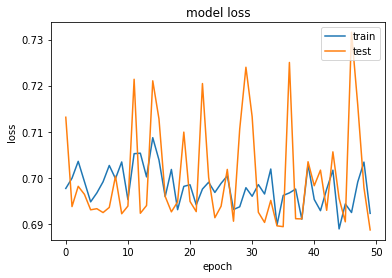

In [162]:
plot_training_history(history)

##### AUC vs epoch

In [163]:
def plot_training_metric(history, metric_name):
    plt.plot(history['metric'])
    plt.plot(history['val_metric'])
    plt.title(f'model {metric_name}')
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

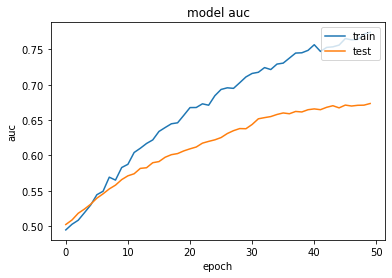

In [164]:
plot_training_metric(history, 'auc')

#### Results explanation

The results are pretty similar to the ones of the Sklearn's linear regression, in both train and test accuracies and AUC.

#### Checking generalization capabilities with more layers

##### 1 extra layer

In [165]:
mlp1 = LogisticRegressionModel(input_size=512, num_hidden_layers=1, hidden_size=64)
mlp1

LogisticRegressionModel(
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [166]:
history = train_model(mlp1, train_dataloader, test_dataloader, epochs=50, learning_rate=1e-4, metric_function=roc_auc_score)

Training started...
epoch 0 loss 0.694459183216095 val_loss 0.696001086384058
epoch 1 loss 0.694506733417511 val_loss 0.6939994022250175
epoch 2 loss 0.6949583089351654 val_loss 0.6962062828242779
epoch 3 loss 0.6957016050815582 val_loss 0.6932790987193584
epoch 4 loss 0.6955228006839752 val_loss 0.6955253928899765
epoch 5 loss 0.6971272790431976 val_loss 0.6964186318218708
epoch 6 loss 0.6960104775428771 val_loss 0.6967466808855534
epoch 7 loss 0.6945063042640686 val_loss 0.6932886503636837
epoch 8 loss 0.6950176060199738 val_loss 0.6949049681425095
epoch 9 loss 0.6944722080230713 val_loss 0.6938125342130661
epoch 10 loss 0.6938297235965729 val_loss 0.6984034217894077
epoch 11 loss 0.6961928498744965 val_loss 0.6942400932312012
epoch 12 loss 0.6945950722694397 val_loss 0.6938584633171558
epoch 13 loss 0.6946459674835205 val_loss 0.6931988336145878
epoch 14 loss 0.6932475447654725 val_loss 0.6932231038808823
epoch 15 loss 0.6946215927600861 val_loss 0.6931308880448341
epoch 16 loss 0.6

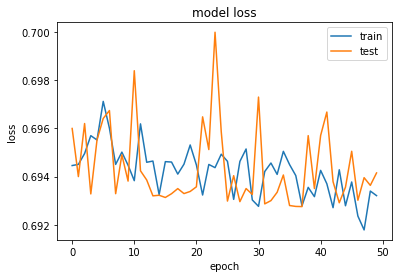

In [167]:
plot_training_history(history)

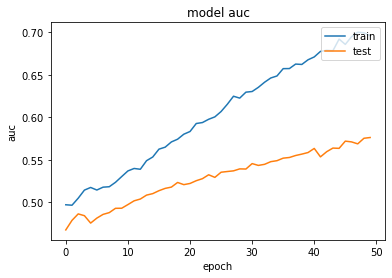

In [168]:
plot_training_metric(history, 'auc')

##### 2 extra layers

In [169]:
mlp2 = LogisticRegressionModel(input_size=512, num_hidden_layers=2, hidden_size=64)
mlp2

LogisticRegressionModel(
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [170]:
history = train_model(mlp2, train_dataloader, test_dataloader, epochs=50, learning_rate=1e-4, metric_function=roc_auc_score)

Training started...
epoch 0 loss 0.6937693452835083 val_loss 0.693334124982357
epoch 1 loss 0.693611456155777 val_loss 0.6932401172816753
epoch 2 loss 0.694267635345459 val_loss 0.693285845220089
epoch 3 loss 0.6934493350982666 val_loss 0.6932261027395725
epoch 4 loss 0.6933156621456146 val_loss 0.6932845786213875
epoch 5 loss 0.6938869214057922 val_loss 0.6931793615221977
epoch 6 loss 0.6939538860321045 val_loss 0.6932131908833981
epoch 7 loss 0.6935126543045044 val_loss 0.6935012489557266
epoch 8 loss 0.6933052802085876 val_loss 0.6931083910167217
epoch 9 loss 0.6933180606365204 val_loss 0.6931393668055534
epoch 10 loss 0.6933841478824615 val_loss 0.6931962296366692
epoch 11 loss 0.6935057139396668 val_loss 0.6931054629385471
epoch 12 loss 0.6933933734893799 val_loss 0.6931554824113846
epoch 13 loss 0.6935648226737976 val_loss 0.6931407526135445
epoch 14 loss 0.6933391690254211 val_loss 0.6931413188576698
epoch 15 loss 0.6932147848606109 val_loss 0.6931494399905205
epoch 16 loss 0.69

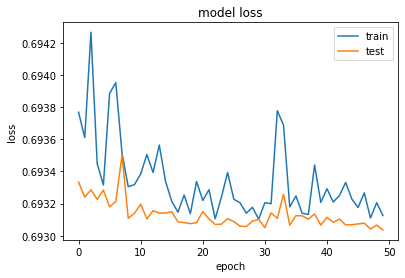

In [171]:
plot_training_history(history)

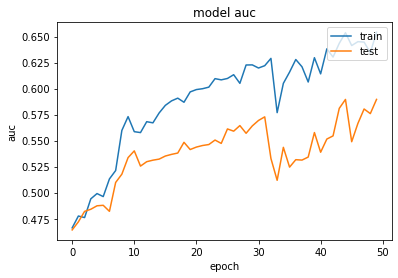

In [172]:
plot_training_metric(history, 'auc')

Adding one or event two layers to the model seems to actually decrease AUC on both train and test sets, so the generalization capabilities of the models are being affected negatively.

**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [173]:
resnet18.fc = logistic_regression_model

In [174]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Comparing  ResNet18 with ResNet34:

#### Download the ResNet34 Network from torchvision.models. Then, repeat the steps described above in order to compare between these ResNet18 and ResNet43. Explain your findings and results!

In [175]:
### START CODE HERE ###
resnet34 = models.resnet34(pretrained=True)
for param in resnet34.parameters():
    param.requires_grad = False
    
resnet34.to(device)    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [176]:
# Remove head
resnet34_feature_extractor = torch.nn.Sequential(*(list(resnet34.children())[:-1]))

In [177]:
train_image_features2, train_labels2 = extract_features(resnet34_feature_extractor, train_dataset, device)
train_image_features2.shape

torch.Size([1600, 512])

In [178]:
test_image_features2, test_labels2 = extract_features(resnet34_feature_extractor, test_dataset, device)
test_image_features2.shape

torch.Size([500, 512])

# Logistic Regression with scikit-learn library:

In [179]:
### START CODE HERE ###
lr = LogisticRegression(max_iter=1000)

In [180]:
train_image_features_array2 = train_image_features2.numpy()
test_image_features_array2 = test_image_features2.numpy()

In [181]:
lr.fit(train_image_features_array2, train_labels2)

LogisticRegression(max_iter=1000)

#### Train accuracy and AUC

In [182]:
predictions = lr.predict(train_image_features_array2)

In [183]:
accuracy = get_accuracy(train_labels2, predictions)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.861875


In [184]:
score = roc_auc_score(train_labels2, predictions)
print(f'Test AUC Score: {score}')

Test AUC Score: 0.861875


#### Test accuracy and AUC

In [185]:
predictions = lr.predict(test_image_features_array2)

In [186]:
accuracy = get_accuracy(test_labels2, predictions)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.762


In [187]:
score = roc_auc_score(test_labels2, predictions)
print(f'Test AUC Score: {score}')

Test AUC Score: 0.762


Using Sklearn's Logistic Regression with features from ResNet34 we obtain similar results in train metrics, but much better results in test accuracy and AUC with respect to the version using ResNet18. With an improvement of over 10%, it closes the gap more between train and test metrics. So we can think that this model has less overfit, and because of that it will have better generalization capability.

# Logistic Regression with pytorch for ResNet34:

#### Define the model:

In [188]:
### START CODE HERE ###
logistic_regression_model2 = LogisticRegressionModel(input_size=512)

#### Training and validation:

In [189]:
### START CODE HERE ###
train_dataloader2 = get_features_dataloader(train_image_features_array2, train_labels2, batch_size=32, shuffle=True)
test_dataloader2 = get_features_dataloader(test_image_features_array2, test_labels2, batch_size=32, shuffle=False)

In [190]:
image, labels = next(iter(train_dataloader))
image.shape, labels.shape

(torch.Size([32, 512]), torch.Size([32]))

In [191]:
image, labels = next(iter(test_dataloader))
image.shape, labels.shape

(torch.Size([32, 512]), torch.Size([32]))

In [192]:
history = train_model(logistic_regression_model2, train_dataloader2, test_dataloader2, epochs=50, learning_rate=1e-3, metric_function=roc_auc_score)

Training started...
epoch 0 loss 0.7000277137756348 val_loss 0.6974107101559639
epoch 1 loss 0.6963261616230011 val_loss 0.6906767673790455
epoch 2 loss 0.6971811962127685 val_loss 0.6894743777811527
epoch 3 loss 0.6990637874603272 val_loss 0.6923157274723053
epoch 4 loss 0.6871934401988983 val_loss 0.6858678869903088
epoch 5 loss 0.6925424289703369 val_loss 0.7098527774214745
epoch 6 loss 0.6992218112945556 val_loss 0.6920823641121387
epoch 7 loss 0.6928649795055389 val_loss 0.6898215897381306
epoch 8 loss 0.6865382027626038 val_loss 0.6876063235104084
epoch 9 loss 0.6837182867527009 val_loss 0.6798848062753677
epoch 10 loss 0.6883646214008331 val_loss 0.6833448298275471
epoch 11 loss 0.6831572020053863 val_loss 0.6850199215114117
epoch 12 loss 0.6804347860813141 val_loss 0.6987492255866528
epoch 13 loss 0.6827758800983429 val_loss 0.6845130957663059
epoch 14 loss 0.6806363618373871 val_loss 0.6758242025971413
epoch 15 loss 0.6798213076591492 val_loss 0.6747753024101257
epoch 16 loss 

#### Visualizing the plots:

##### Loss vs epoch

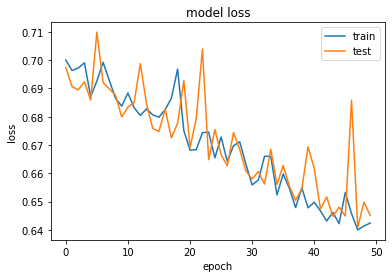

In [193]:
### START CODE HERE ###
plot_training_history(history)

##### AUC vs epoch

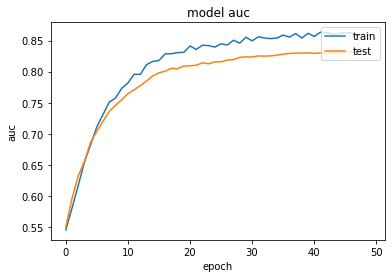

In [194]:
plot_training_metric(history, 'auc')

Using the Logistic Regression model implemented in PyTorch with features of ResNet34 performs a little better than it's Sklearn counterpart, with an improvement of around 10% AUC.

#### Checking generalization capabilities with more layers

##### 1 extra layer

In [195]:
mlp1 = LogisticRegressionModel(input_size=512, num_hidden_layers=1, hidden_size=64)
mlp1

LogisticRegressionModel(
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [196]:
history = train_model(mlp1, train_dataloader2, test_dataloader2, epochs=50, learning_rate=1e-4, metric_function=roc_auc_score)

Training started...
epoch 0 loss 0.6949782288074493 val_loss 0.6932906061410904
epoch 1 loss 0.6936232054233551 val_loss 0.6925728768110275
epoch 2 loss 0.6935449743270874 val_loss 0.6933583915233612
epoch 3 loss 0.6938564801216125 val_loss 0.6924497671425343
epoch 4 loss 0.693564635515213 val_loss 0.692080520093441
epoch 5 loss 0.6928508639335632 val_loss 0.6919007301330566
epoch 6 loss 0.692512389421463 val_loss 0.691378016024828
epoch 7 loss 0.6936793458461762 val_loss 0.6917511932551861
epoch 8 loss 0.6923310577869415 val_loss 0.6909079141914845
epoch 9 loss 0.6913848221302032 val_loss 0.6906678751111031
epoch 10 loss 0.692235951423645 val_loss 0.690680094063282
epoch 11 loss 0.6919335210323334 val_loss 0.6903036087751389
epoch 12 loss 0.6911122488975525 val_loss 0.6912592239677906
epoch 13 loss 0.6908443856239319 val_loss 0.6927613504230976
epoch 14 loss 0.6905517435073852 val_loss 0.6898122765123844
epoch 15 loss 0.6907891321182251 val_loss 0.6895710229873657
epoch 16 loss 0.6908

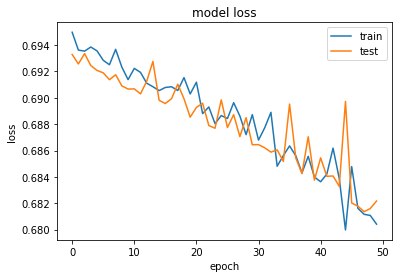

In [197]:
plot_training_history(history)

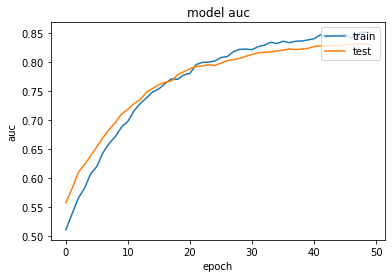

In [198]:
plot_training_metric(history, 'auc')

##### 2 extra layers

In [199]:
mlp2 = LogisticRegressionModel(input_size=512, num_hidden_layers=2, hidden_size=64)
mlp2

LogisticRegressionModel(
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [200]:
history = train_model(mlp2, train_dataloader2, test_dataloader2, epochs=50, learning_rate=1e-4, metric_function=roc_auc_score)

Training started...
epoch 0 loss 0.6935850739479065 val_loss 0.6930901408195496
epoch 1 loss 0.6935507774353027 val_loss 0.6931574754416943
epoch 2 loss 0.6931943154335022 val_loss 0.6927739307284355
epoch 3 loss 0.6932446348667145 val_loss 0.692910797894001
epoch 4 loss 0.6929292619228363 val_loss 0.6926172450184822
epoch 5 loss 0.6931601512432098 val_loss 0.6926923915743828
epoch 6 loss 0.6929480445384979 val_loss 0.6926032640039921
epoch 7 loss 0.6931100010871887 val_loss 0.6925576478242874
epoch 8 loss 0.6928023123741149 val_loss 0.6925655789673328
epoch 9 loss 0.692866085767746 val_loss 0.6924377605319023
epoch 10 loss 0.6926034724712372 val_loss 0.6923700347542763
epoch 11 loss 0.6930130290985107 val_loss 0.6922965236008167
epoch 12 loss 0.6933696794509888 val_loss 0.6926080584526062
epoch 13 loss 0.6920747458934784 val_loss 0.6927360333502293
epoch 14 loss 0.6929075276851654 val_loss 0.6923155337572098
epoch 15 loss 0.6925975489616394 val_loss 0.6922713667154312
epoch 16 loss 0.

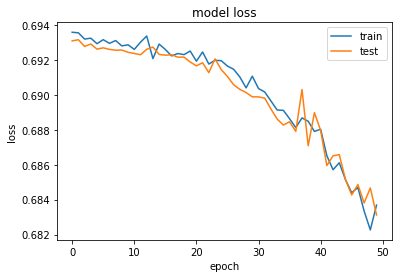

In [201]:
plot_training_history(history)

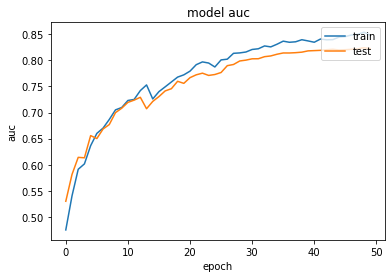

In [202]:
plot_training_metric(history, 'auc')

In this case, it looks like adding one or two layers does not affect the generalization capabilities of the model, as the AUC values are pretty similar in all model variations.

**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [203]:
### START CODE HERE ###
resnet34.fc = logistic_regression_model2

In [204]:
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Part 2- Fine-tuning

In the feature extraction experiment above you were training the classifier on the top of the pre-trained model. 
In this paert, you need to train (or "fine-tune") the original pre-trained Resnet18 model (or part of them) in an attempts to improve your results. You can determine the number of convolution layers you intend to re-train in order to avoid overfitting and hopefully achive better generalization. Note that the fine-tuning should only be attempted after you have trained the top-level classifier with a pre-trained model.

1. Plot Loss and Accuracy v.s Epoch for train and validation sets:

#### Define the model (use the merged feature extractor with the PyTorch logistic regression classifier)

In [205]:
### START CODE HERE ###

# Make all parameters trainable
for param in resnet18.parameters():
    param.requires_grad = True

In [206]:
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Training and validation:

In [207]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [208]:
### START CODE HERE ###
history = train_model(resnet18, train_dataloader, test_dataloader, epochs=25, learning_rate=1e-6, metric_function=roc_auc_score, device=device)

Training started...
epoch 0 loss 0.5875801610946655 val_loss 0.5873379521071911
epoch 1 loss 0.5584281456470489 val_loss 0.5697995219379663
epoch 2 loss 0.5369543933868408 val_loss 0.5542621947824955
epoch 3 loss 0.511661211848259 val_loss 0.5348428208380938
epoch 4 loss 0.4918479835987091 val_loss 0.5225654747337103
epoch 5 loss 0.46820280253887175 val_loss 0.5067156683653593
epoch 6 loss 0.44723684668540953 val_loss 0.49880125001072884
epoch 7 loss 0.42855058670043944 val_loss 0.48879053443670273
epoch 8 loss 0.4150882416963577 val_loss 0.4779073838144541
epoch 9 loss 0.39707611620426175 val_loss 0.4642060659825802
epoch 10 loss 0.3847912448644638 val_loss 0.4571465849876404
epoch 11 loss 0.3662031084299088 val_loss 0.4521678499877453
epoch 12 loss 0.35411625921726225 val_loss 0.44490768387913704
epoch 13 loss 0.3400027346611023 val_loss 0.43916825763881207
epoch 14 loss 0.3308902734518051 val_loss 0.43358675576746464
epoch 15 loss 0.3204628652334213 val_loss 0.427776288241148
epoch 

#### Visualizing the plots:

##### Loss vs epoch

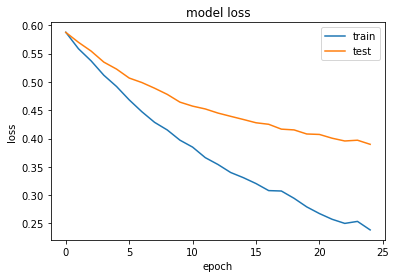

In [209]:
plot_training_history(history)

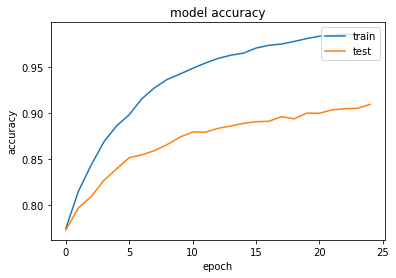

In [210]:
plot_training_metric(history, 'accuracy')

##### AUC vs epoch

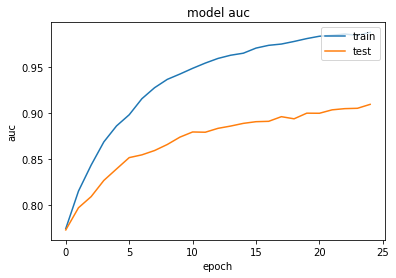

In [211]:
plot_training_metric(history, 'auc')

2. Compare your results between the two approaches. Is there any improvement? Explain your findings...


Type your answer here:


There is a big improvement in AUC for the fine-tuned model, that went up to around 90% AUC (up from 65%).

The pretraining of the logistic regression head and fine-tuning of the whole model did improve the results over just using the extracted features with the logistic regression model.

So right here is an example of the value that the fine-tunning process has over the generalization capabilities of the model.